In [213]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, plot_tree
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
import lightgbm as lgb
from catboost import CatBoostClassifier
from xgboost import XGBClassifier, callback, plot_importance
import matplotlib.pyplot as plt

import warnings 
warnings.filterwarnings("ignore")

In [214]:
def calibracion(predicciones, y, bins):
    df_calibracion = pd.DataFrame({
        'predicciones':predicciones,
        'y':y
    })
    df_calibracion['bins'] = pd.qcut(df_calibracion['predicciones'], q=bins, labels=False, duplicates='drop')+1
    grouped = df_calibracion.groupby('bins').mean()

    plt.plot(grouped.predicciones, grouped.y, label="Modelo", marker="o")
    plt.plot(grouped.predicciones, grouped.predicciones, label="Real", marker="o")
    plt.grid()
    plt.legend()
    plt.xlabel("Prediccion")
    plt.ylabel("Real")

In [215]:
df = pd.read_csv("Data/hr_role.csv")
df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,is_satisfied
0,41,1,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,...,80,0,8,0,1,6,4,0,5,True
1,49,0,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,...,80,1,10,3,3,10,7,1,7,False
2,37,1,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,...,80,0,7,3,3,0,0,0,0,False
3,33,0,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,...,80,0,8,3,3,8,7,3,0,False
4,27,0,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,...,80,1,6,3,3,2,2,2,2,False


In [216]:
df = pd.get_dummies(df)
df.head()

,Age,Attrition,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Over18_Y,OverTime_No,OverTime_Yes
0,41,1,1102,1,2,2,94,3,2,5993,...,0,0,1,0,0,0,1,1,0,1
1,49,0,279,8,1,3,61,2,2,5130,...,0,1,0,0,0,1,0,1,1,0
2,37,1,1373,2,2,4,92,2,1,2090,...,0,0,0,0,0,0,1,1,0,1
3,33,0,1392,3,4,4,56,3,1,2909,...,0,1,0,0,0,1,0,1,0,1
4,27,0,591,2,1,1,40,3,1,3468,...,0,0,0,0,0,1,0,1,1,0


In [217]:
target = 'Attrition'
y = df[target]

In [218]:
X = df.copy().drop(target, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [219]:
arbol2 = DecisionTreeClassifier(max_depth=2).fit(X_train, y_train)

# Arbol Max Depth 2

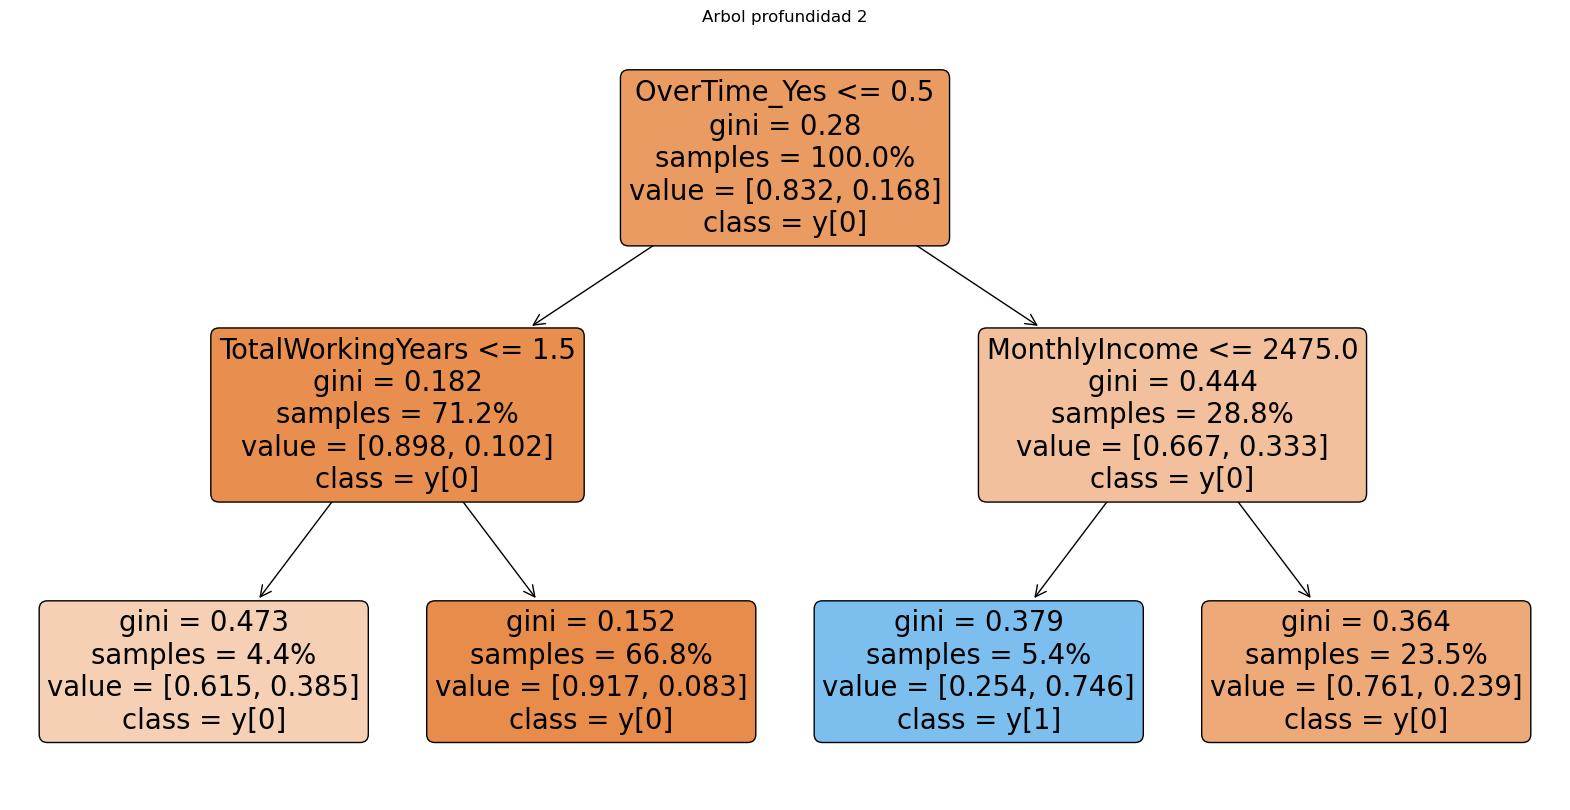

In [221]:
plt.figure(figsize=(20, 10))
plot_tree(arbol2, filled=True, feature_names=X.columns, class_names=True,rounded=True, proportion=True)
plt.title("Arbol profundidad 2")
plt.show()

Despúes de realizar este arbol con profundidad podemos ver las diferentes variables importantes en el desgaste de los empleados, primero vemos que el arbol toma en cuenta si la persona trabaja horas extra o no, en el siguiente nivel vemos las variables monthly income creando un corte en un income mensual de $2,475 y Total Working Years creando un corte en 1.5 años trabajados, viendo el arbol notamos que la gente que no trabaja horas extras y que ademas llevan más de 1.5 años trabajando en la empresa son menos probables a tener desgasto, por otro lado la gente que tiene una probabilidad mayor a tener desgaste en la empresa o attrition son las personas que ganan menos de $2,475 mensuales y que además trabajan horas extras.

# Mejor Arbol de Decision

In [169]:
pipeline = Pipeline([
    ('tree', DecisionTreeClassifier(random_state=42))
])

params = {
    'tree__max_depth': list(range(1, 10)),
    'tree__max_features': ['log2', 'sqrt', None],
    'tree__min_samples_split': list(range(2, 10)),
    'tree__min_samples_leaf': list(range(1, 10))
}

grid_tree = GridSearchCV(pipeline, params, cv=5, n_jobs=-1, scoring='roc_auc')
grid_tree.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tree',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'tree__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'tree__max_features': ['log2', 'sqrt', None],
                         'tree__min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'tree__min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9]},
             scoring='roc_auc')

In [170]:
best_model = grid_tree.best_estimator_.named_steps['tree']
probabilidades = best_model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_score = probabilidades, y_true=y_test)

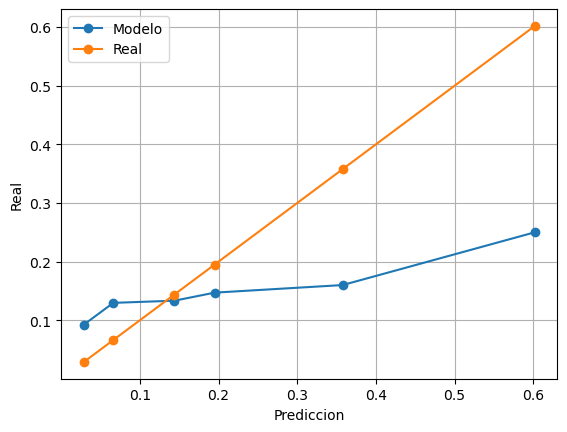

In [ ]:
calibracion (probabilidades, y_test, 10)

In [172]:
roc_auc_score(y_test, probabilidades)

0.5947209653092006

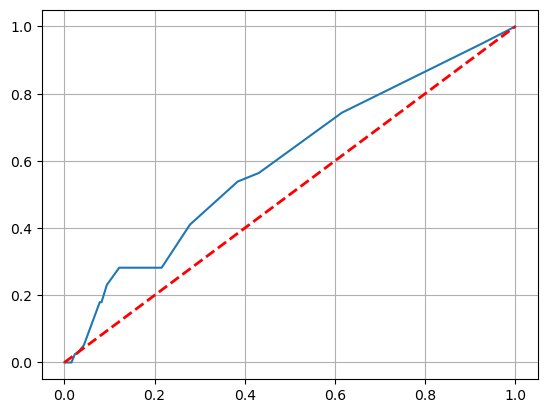

In [ ]:
fpr, fnp, scores = roc_curve(y_score=probabilidades, y_true=y_test)
plt.plot(fpr, fnp)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Clasificador aleatorio')
plt.grid()
plt.show()

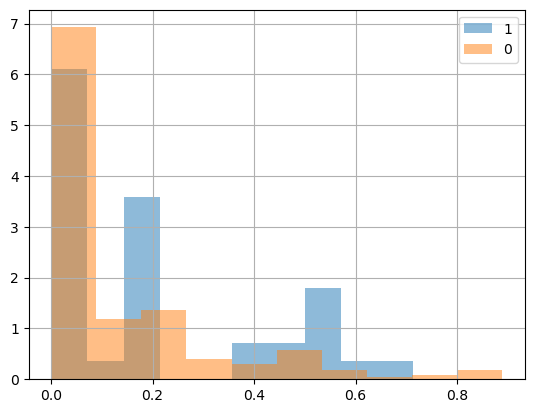

In [ ]:
histograma = pd.DataFrame({'target': y_test, 'probabilidades': probabilidades})

proba_1 = histograma[histograma['target'] == 1].probabilidades
proba_0 = histograma[histograma['target']== 0].probabilidades

plt.hist(proba_1, alpha=0.5, density=True, label='1')
plt.hist(proba_0, alpha=0.5, density=True, label='0')
plt.grid()
plt.legend()
plt.show()

# Random Forest

In [ ]:
pipeline = Pipeline([
    ('rf', RandomForestClassifier(n_jobs=-1, random_state=42))
])

params = {
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': list(range(1, 20)),
    'rf__max_features': ['log2', 'sqrt', 10, 12]
}

rf_grid = GridSearchCV(estimator=pipeline, n_jobs=-1, cv=5, scoring='roc_auc', param_grid=params)
rf_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('rf',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                           12, 13, 14, 15, 16, 17, 18, 19],
                         'rf__max_features': ['log2', 'sqrt', 10, 12],
                         'rf__n_estimators': [100, 200, 300]},
             scoring='roc_auc')

In [176]:
best_model = rf_grid.best_estimator_.named_steps['rf']
probabilidades = best_model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_score = probabilidades, y_true=y_test)

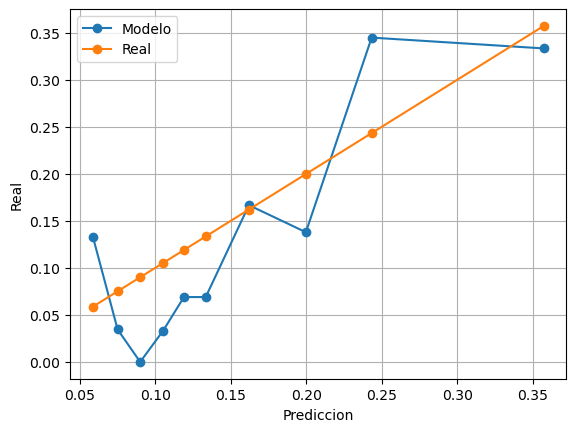

In [ ]:
calibracion(probabilidades, y_test, 10)

In [178]:
auc_score = roc_auc_score(y_test, probabilidades)
auc_score

0.7319255907491201

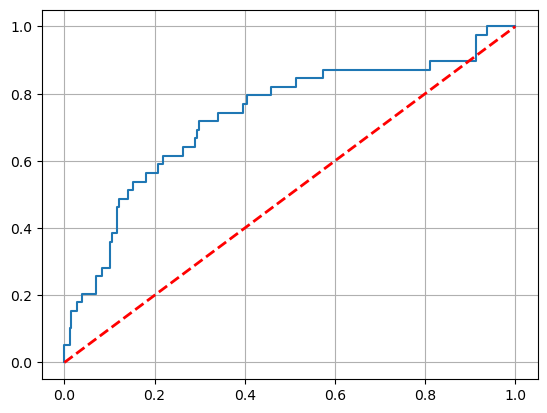

In [ ]:
fpr, fnp, scores = roc_curve(y_score=probabilidades, y_true=y_test)
plt.plot(fpr, fnp)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Clasificador aleatorio')
plt.grid()
plt.show()

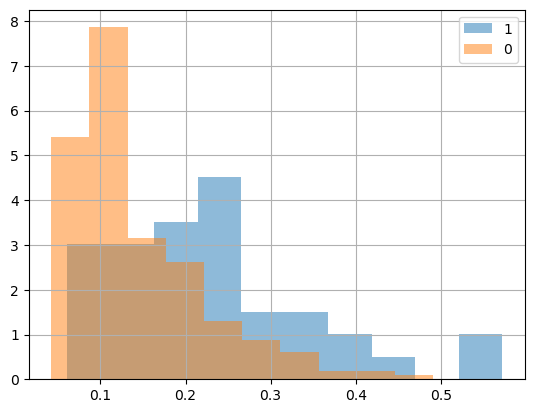

In [ ]:
histograma = pd.DataFrame({'target': y_test, 'probabilidades': probabilidades})

proba_1 = histograma[histograma['target'] == 1].probabilidades
proba_0 = histograma[histograma['target']== 0].probabilidades

plt.hist(proba_1, alpha=0.5, density=True, label='1')
plt.hist(proba_0, alpha=0.5, density=True, label='0')
plt.grid()
plt.legend()
plt.show()

## Feature Importance Random Forest

In [ ]:
model_interpretability = pd.DataFrame({
    'variables': X_train.keys(),
    'importancia': best_model.feature_importances_
})
model_interpretability

,variables,importancia
0,Age,0.048262
1,DailyRate,0.031662
2,DistanceFromHome,0.026513
3,Education,0.010120
4,EnvironmentSatisfaction,0.018033
5,HourlyRate,0.018770
6,JobInvolvement,0.018837
7,JobLevel,0.046603
8,MonthlyIncome,0.091207
9,MonthlyRate,0.025741


# XGBoost

In [ ]:
model = XGBClassifier(
    n_estimators=10000,
    max_depth=5,
    learning_rate = 0.1,
    reg_lambda=0.1,
    subsample = 0.5,
    col_sample_by_tree = 0.8,
    tree_method='hist'
)

model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], early_stopping_rounds=20, verbose=100)


[16:55:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "col_sample_by_tree" } are not used.

[0]	validation_0-logloss:0.63169	validation_1-logloss:0.64144
[89]	validation_0-logloss:0.08376	validation_1-logloss:0.34377


XGBClassifier(base_score=None, booster=None, callbacks=None,
              col_sample_by_tree=0.8, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=None, num_parallel_tree=None,
              predictor=None, ...)

In [183]:
best_model = model
probabilidades = best_model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_score= probabilidades, y_true=y_test)
auc_score

0.7722473604826546

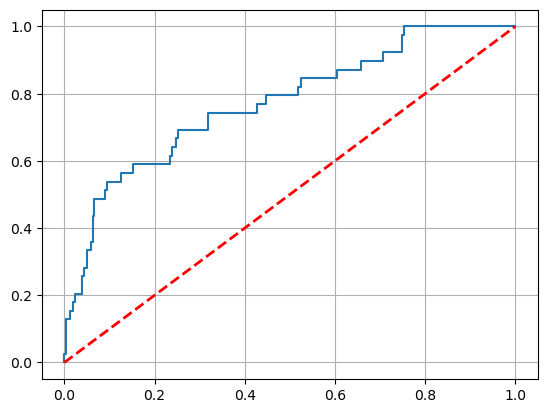

In [ ]:
fpr, fnp, scores = roc_curve(y_score=probabilidades, y_true=y_test)
plt.plot(fpr, fnp)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Clasificador aleatorio')
plt.grid()
plt.show()

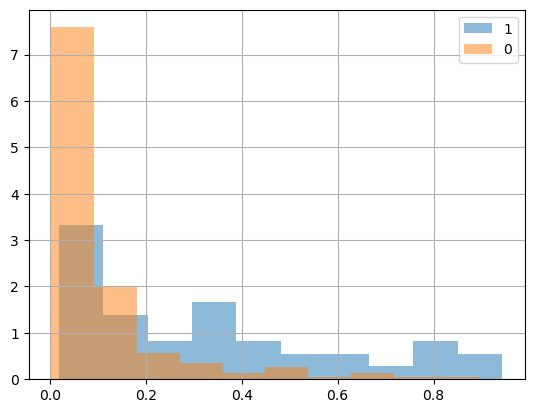

In [185]:
histograma = pd.DataFrame({'target': y_test, 'probabilidades': probabilidades})

proba_1 = histograma[histograma['target'] == 1].probabilidades
proba_0 = histograma[histograma['target']== 0].probabilidades

plt.hist(proba_1, alpha=0.5, density=True, label='1')
plt.hist(proba_0, alpha=0.5, density=True, label='0')
plt.grid()
plt.legend()
plt.show()

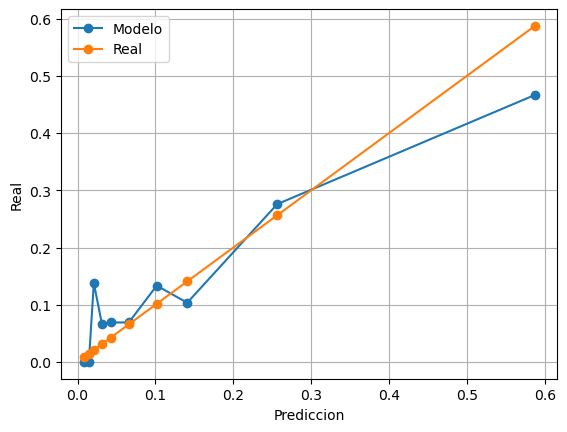

In [186]:
calibracion(probabilidades, y_test, 10)

## Feature Importance XGBoost

In [187]:
model_interpretability = pd.DataFrame({
    'variables': X_train.keys(),
    'importancia': best_model.feature_importances_
})
model_interpretability

,variables,importancia
0,Age,0.021117
1,DailyRate,0.017566
2,DistanceFromHome,0.019300
3,Education,0.016141
4,EnvironmentSatisfaction,0.021640
5,HourlyRate,0.018352
6,JobInvolvement,0.024049
7,JobLevel,0.035634
8,MonthlyIncome,0.023550
9,MonthlyRate,0.018598


## Weight XGBoost

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

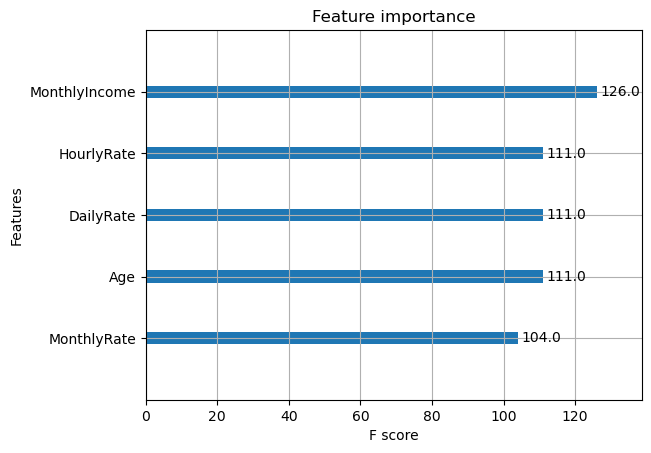

In [188]:
plot_importance(model, max_num_features=5, importance_type='weight')

## Gain XGBoost

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

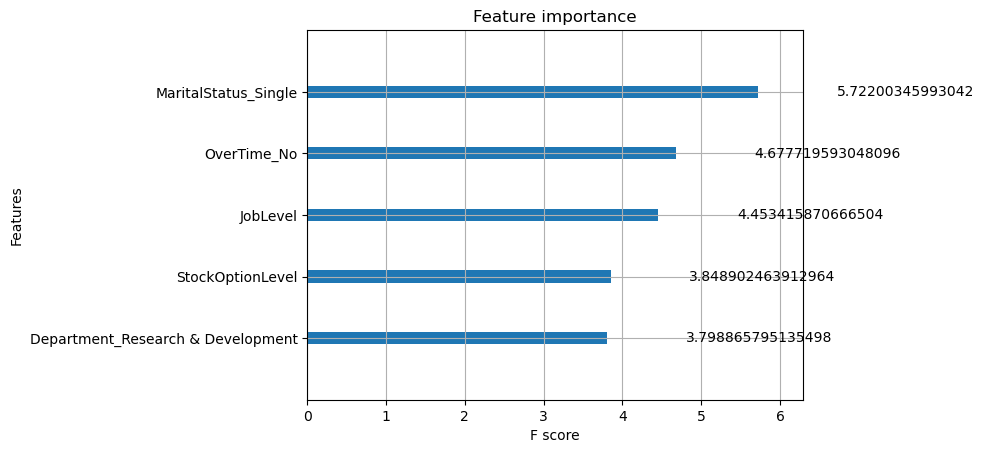

In [189]:
plot_importance(model, max_num_features=5, importance_type='gain')

# LightGBM

In [ ]:
model = LGBMClassifier(
    num_iterations=10000,
    num_leaves=10,
    learning_rate=0.1,
    max_depth=6,
    lambda_l2=0.1,
    subsample=0.5,
    feature_fraction=0.8,
    verbosity=-1,
    metric='auc'
)

model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], callbacks=[early_stopping(20)])

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[93]	training's auc: 0.996716	valid_1's auc: 0.78904


LGBMClassifier(feature_fraction=0.8, lambda_l2=0.1, max_depth=6, metric='auc',
               num_iterations=10000, num_leaves=10, subsample=0.5,
               verbosity=-1)

In [191]:
best_model = model
probabilidades = best_model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_score= probabilidades, y_true=y_test)
auc_score

0.7890397184514831

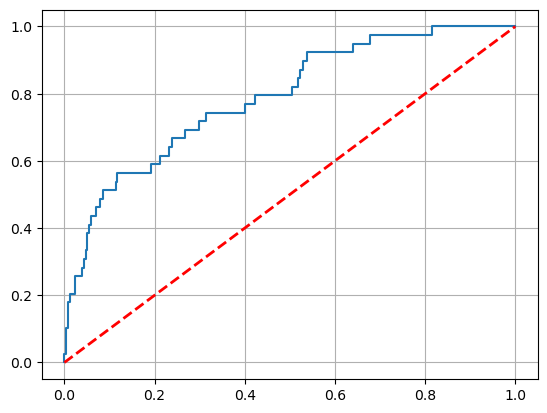

In [192]:
fpr, fnp, scores = roc_curve(y_score=probabilidades, y_true=y_test)
plt.plot(fpr, fnp)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Clasificador aleatorio')
plt.grid()
plt.show()

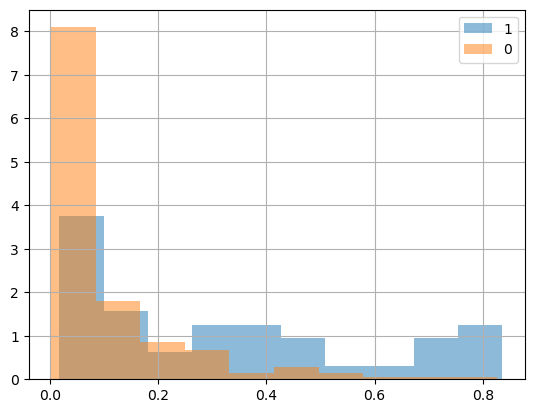

In [ ]:
histograma = pd.DataFrame({'target': y_test, 'probabilidades': probabilidades})

proba_1 = histograma[histograma['target'] == 1].probabilidades
proba_0 = histograma[histograma['target']== 0].probabilidades

plt.hist(proba_1, alpha=0.5, density=True, label='1')
plt.hist(proba_0, alpha=0.5, density=True, label='0')
plt.grid()
plt.legend()
plt.show()

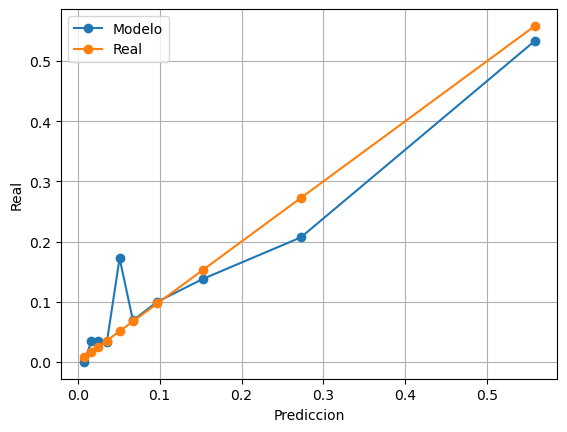

In [194]:
calibracion(probabilidades, y_test, 10)

## Split LightGBM

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

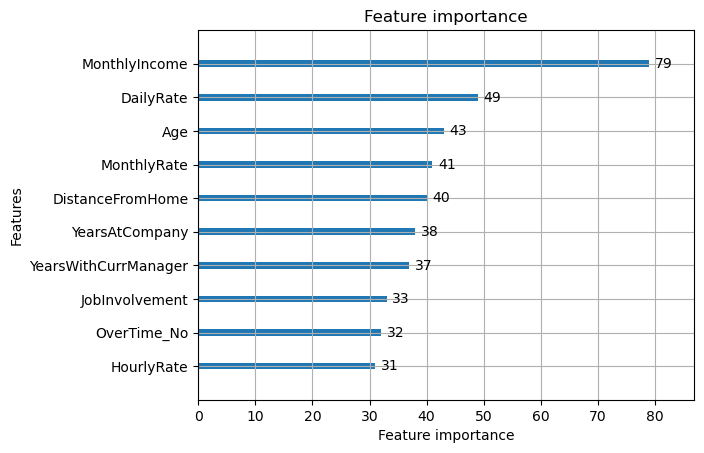

In [196]:
lgb.plot_importance(model, max_num_features=10, importance_type='split')

## Gain LightGBM

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

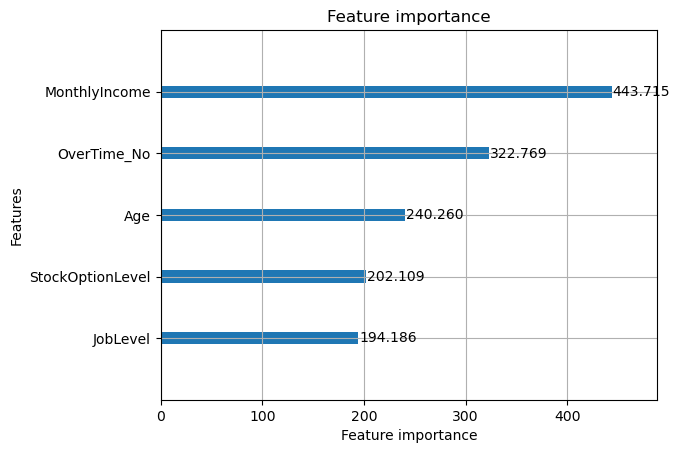

In [197]:
lgb.plot_importance(model, max_num_features=5, importance_type='gain')

# Catboost

In [198]:
cat_cols = [col for col in X_train.columns if X_train[col].nunique() < 50]
for col in cat_cols:
    X_train[col] = X_train[col].astype(str).fillna('missing')
    X_test[col] = X_test[col].astype(str).fillna('missing')

model = CatBoostClassifier(
    iterations=10000,          
    depth=5,                
    learning_rate=0.5,
    subsample=0.25,            
    rsm=0.8,                    
    eval_metric='AUC',           
    l2_leaf_reg=0.1,            
    random_strength=5,         
    verbose=100,
    early_stopping_rounds=20    
)

model.fit(
    X_train, y_train,
    cat_features=cat_cols,
    eval_set=[(X_test, y_test)],
)

0:	test: 0.6429361	best: 0.6429361 (0)	total: 4.57ms	remaining: 45.7s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7652086476
bestIteration = 34

Shrink model to first 35 iterations.


In [199]:
best_model = model
probabilidades = best_model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_score= probabilidades, y_true=y_test)
auc_score

0.7652086475615887

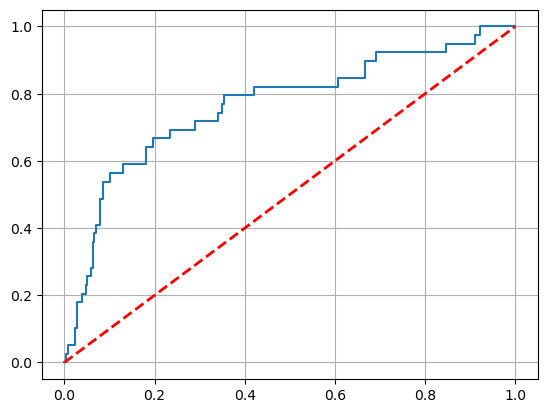

In [ ]:
fpr, fnp, scores = roc_curve(y_score=probabilidades, y_true=y_test)
plt.plot(fpr, fnp)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Clasificador aleatorio')
plt.grid()
plt.show()

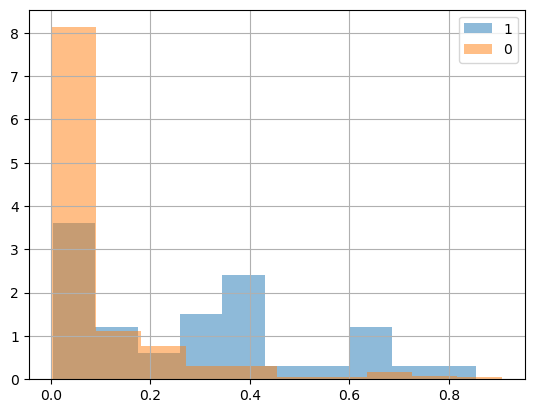

In [ ]:
histograma = pd.DataFrame({'target': y_test, 'probabilidades': probabilidades})

proba_1 = histograma[histograma['target'] == 1].probabilidades
proba_0 = histograma[histograma['target']== 0].probabilidades

plt.hist(proba_1, alpha=0.5, density=True, label='1')
plt.hist(proba_0, alpha=0.5, density=True, label='0')
plt.grid()
plt.legend()
plt.show()

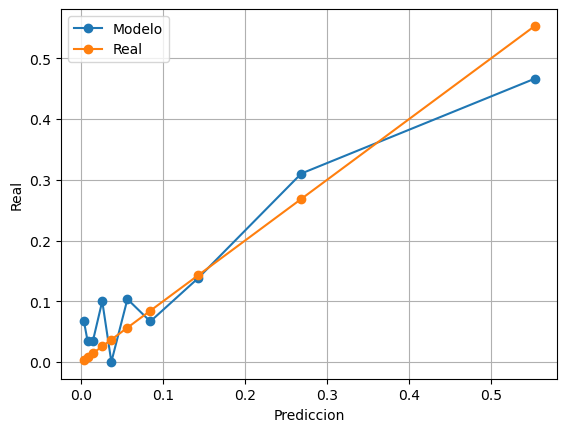

In [ ]:
calibracion(probabilidades, y_test, 10)

In [203]:
model_interpretability = pd.DataFrame({
    'variables': X_train.keys(),
    'importancia': best_model.feature_importances_
})
model_interpretability

,variables,importancia
0,Age,5.364750
1,DailyRate,7.809792
2,DistanceFromHome,6.064001
3,Education,1.439146
4,EnvironmentSatisfaction,3.688816
5,HourlyRate,2.377459
6,JobInvolvement,2.922232
7,JobLevel,4.924327
8,MonthlyIncome,6.265483
9,MonthlyRate,5.281431


# Conclusiones

Después de realizar los diferentes modelos podemos ver que el mejor modelo para predecir Attrition fue el de LightGBM con AUC de 0.7890, después el mejor modelo fue el de XGBoost con un AUC de 0.7722, después el de Catboost con un AUC de 0.7652 y por último el random forest con un AUC de 0.7319.

Analizando el LightGBM vemos que las variables que más utilizo el modelo fueron la de MonthlyIncome que se utilizo 79, después DailyRate con 49 veces utilizada y Age con 43 veces utilizada, esas fueron las 3 más utilizadas en el modelo de LightGBM, analizando el Gain de este mismo modelo nos damos cuenta que las variables que más ayudaron a reducir el error del modelo fueron MonthlyIncome, OvertimeNo y Age, siendo las más importantes como se menciono anteriormente para la reducción del error del modelo.

Es interesante ver como al realizar el mejor arbol de decisión posible que da un AUC de 0.5947 no se acerca nada a los modelos realizados como random forest, Catboost, LightGBM y XGBoost, aunque es cierto que realizar alguno de estos modelos resulta ser más caro computacionalmente, sin duda es altamente recomendado el realizar alguno de estos ya que la métrica en este caso del AUC aumenta bastante.

